Make the general imports

In [1]:
from fastai import *
from fastai.vision.all import *
from fastai.metrics import error_rate, accuracy
%reload_ext autoreload
%autoreload 2
%matplotlib inline

define the path to our data

In [2]:
path = '../input/fruits/fruits-360'

In [3]:
fruit_data = get_image_files(path)

Let us look at our data

In [4]:
len(fruit_data)

90483

90 483 images in total

In [5]:
train = get_image_files(path+'/Training')
test = get_image_files(path+'/Test')

print(f"Train: {len(train)}, Test: {len(test)}")

Train: 67692, Test: 22688


The train and test sets are defined but we will use DataBlock to randomly split the data into the train and validation sets with 20% being set aside for the validation set. Our data has images and categories so we pass both ImageBlock and CategoryBlock. With get_items we find where our data is stored and with get_y we get the labels .We transform our data by taking each item and normalising it to 128x128 using item_tfms. Datablock help in getting our data into a form that can be fed into our model.

In [6]:
fruits = DataBlock (
    blocks = (ImageBlock, CategoryBlock),
    get_items = get_image_files,
    splitter = RandomSplitter(valid_pct=0.2, seed=42),
    get_y = parent_label,
    item_tfms = Resize(128)
)

At this point fruits is an empty object it defines how we want to load the data with the help of DataBlock.To load the data we call the dataloaders.

In [7]:
dls = fruits.dataloaders(path)

the show_batch method helps us take a peek at the data so far, you can pass in max_n and n_row to define how many images you want to see. 

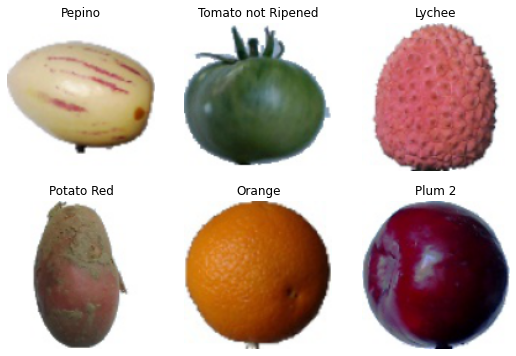

In [8]:
dls.show_batch(max_n=6, nrows=2)

We can also transform our data gain by resizing it item by item and passing batch_tfms to transform it by batch. The latter is a data augmentation technique applied on the GPU to help process the data in "batches".

In [9]:
fruits = fruits.new(item_tfms=RandomResizedCrop(224, min_scale=0.5),
                   batch_tfms=aug_transforms())

We can take a look again

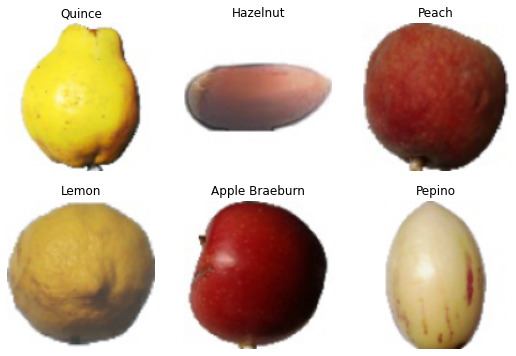

In [10]:
dls.show_batch(max_n=6, nrows=2)

Since we are using transfer learning we will choose a pretrained model, for this example we will choose resnet34. Fastai allows us to pick the metrics we want and in this case I chose accuracy and error_rate as we have a classification problem. 

In [11]:
learn = cnn_learner(dls,resnet34, metrics=[accuracy, error_rate])

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


Fastai also has a great tool which suggests what learning rate to use,the learning rate is typcally the steepest point of a gradient descent curve.

SuggestedLRs(lr_min=0.010000000149011612, lr_steep=0.0063095735386013985)

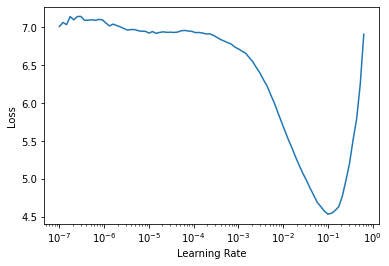

In [12]:
learn.lr_find()

We pass in the suggested learning rate and train our model which is also evident as the steepest point in the above plot.

In [14]:
learn.fine_tune(4, 1e-2)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.054060,0.003699,0.999503,0.000497,04:33


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.067560,0.027004,0.994363,0.005637,04:23
1,0.026745,0.003254,0.999503,0.000497,04:24
2,0.002711,0.001965,0.999834,0.000166,04:32
3,0.000556,0.001598,0.999945,0.000055,04:24


Let us interpret our results

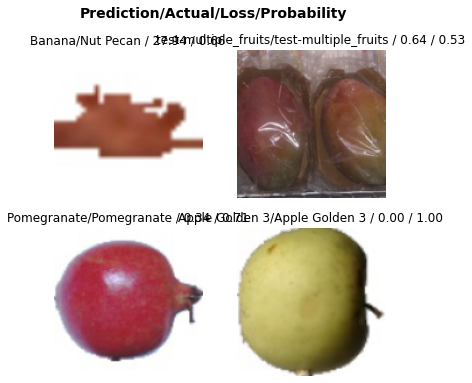

In [15]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_top_losses(4)

A better look at the losses by defining the figsize

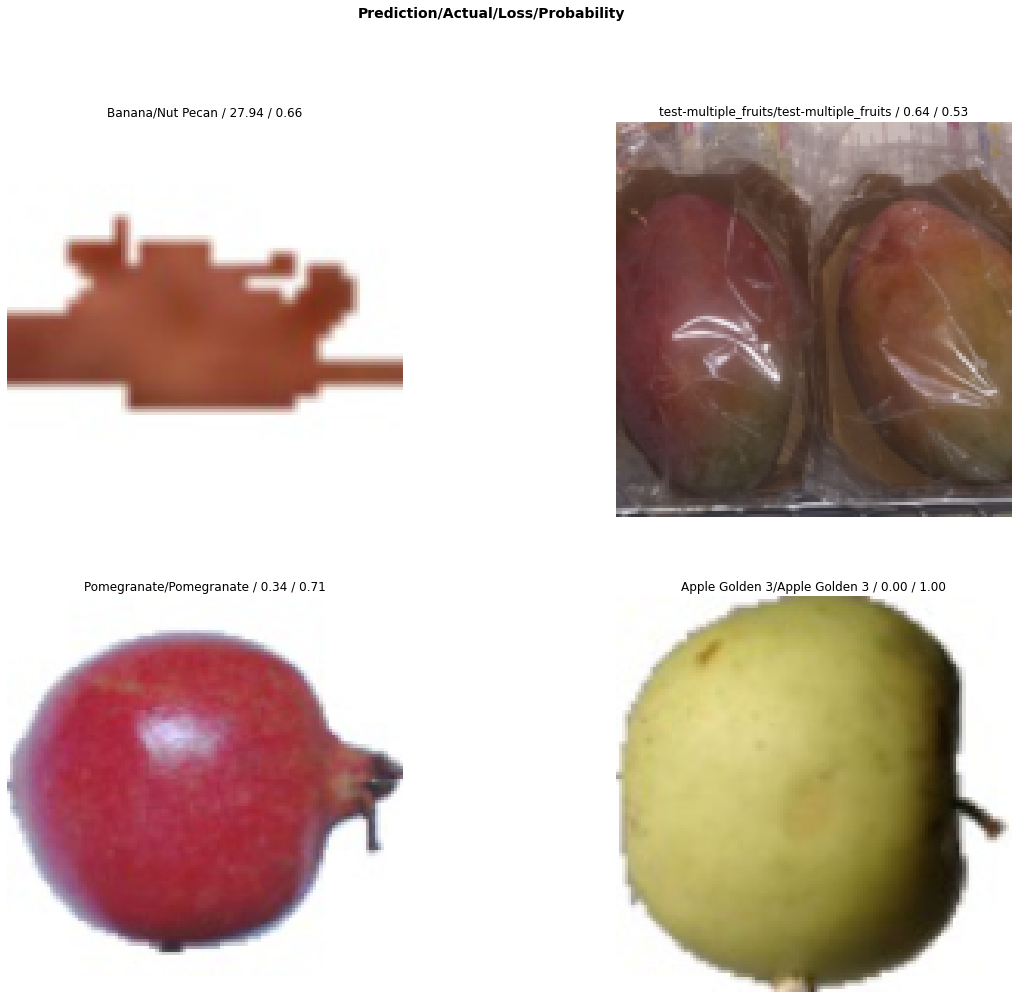

In [16]:
interp.plot_top_losses(4, figsize=(20,16))

We can also plot a confusion matrix

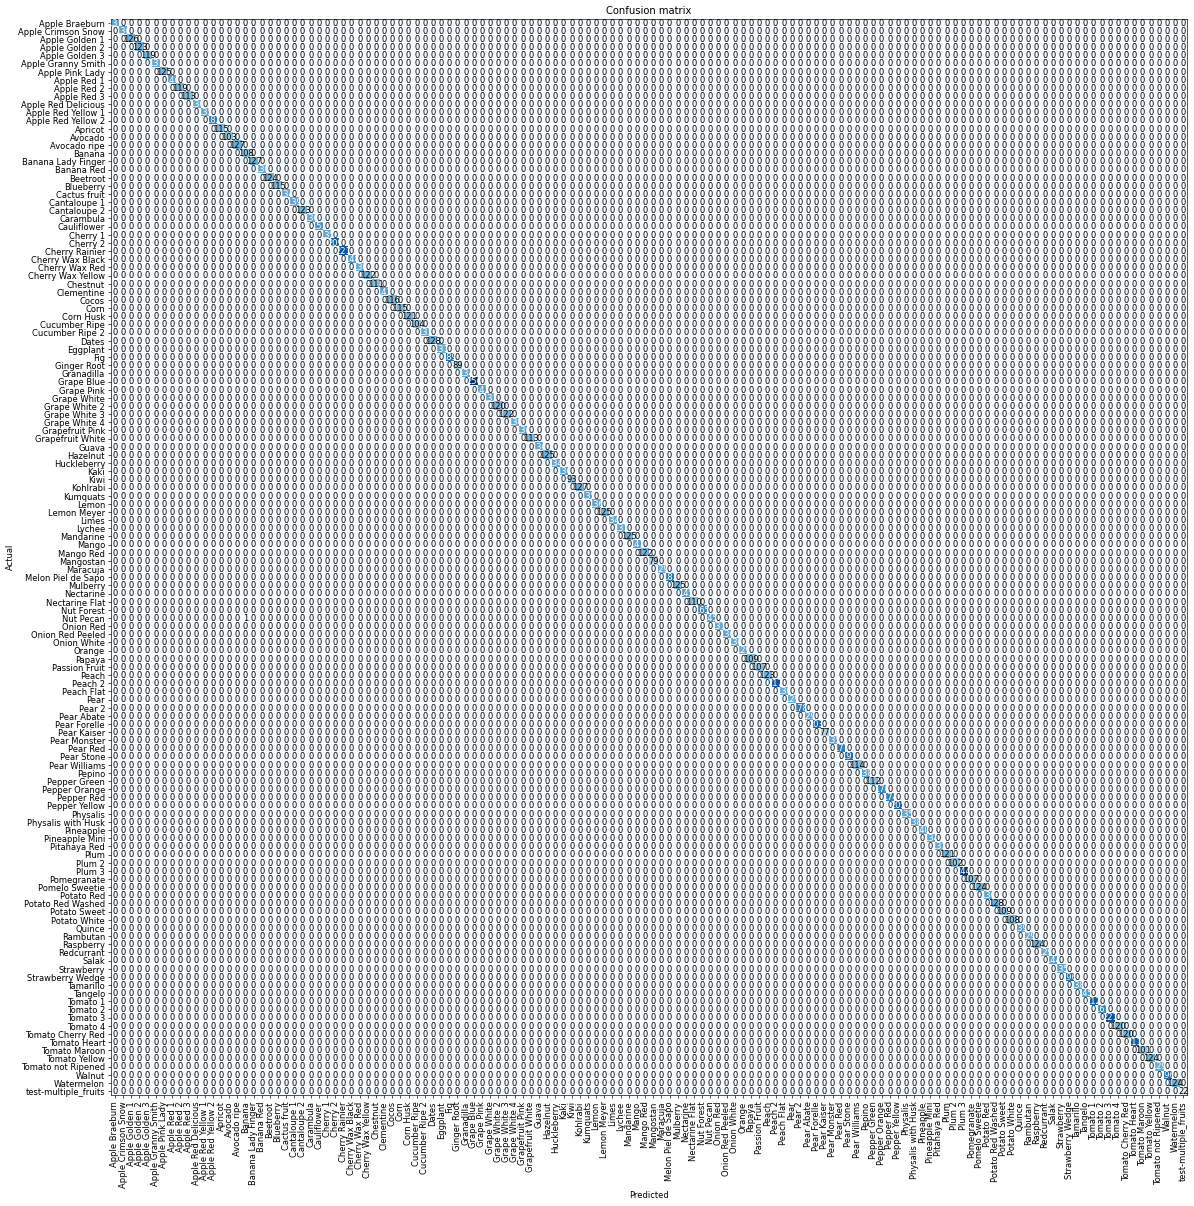

In [17]:
interp.plot_confusion_matrix(figsize=(20,20), dpi=60)

In [18]:
interp.vocab

['Apple Braeburn', 'Apple Crimson Snow', 'Apple Golden 1', 'Apple Golden 2', 'Apple Golden 3', 'Apple Granny Smith', 'Apple Pink Lady', 'Apple Red 1', 'Apple Red 2', 'Apple Red 3', 'Apple Red Delicious', 'Apple Red Yellow 1', 'Apple Red Yellow 2', 'Apricot', 'Avocado', 'Avocado ripe', 'Banana', 'Banana Lady Finger', 'Banana Red', 'Beetroot', 'Blueberry', 'Cactus fruit', 'Cantaloupe 1', 'Cantaloupe 2', 'Carambula', 'Cauliflower', 'Cherry 1', 'Cherry 2', 'Cherry Rainier', 'Cherry Wax Black', 'Cherry Wax Red', 'Cherry Wax Yellow', 'Chestnut', 'Clementine', 'Cocos', 'Corn', 'Corn Husk', 'Cucumber Ripe', 'Cucumber Ripe 2', 'Dates', 'Eggplant', 'Fig', 'Ginger Root', 'Granadilla', 'Grape Blue', 'Grape Pink', 'Grape White', 'Grape White 2', 'Grape White 3', 'Grape White 4', 'Grapefruit Pink', 'Grapefruit White', 'Guava', 'Hazelnut', 'Huckleberry', 'Kaki', 'Kiwi', 'Kohlrabi', 'Kumquats', 'Lemon', 'Lemon Meyer', 'Limes', 'Lychee', 'Mandarine', 'Mango', 'Mango Red', 'Mangostan', 'Maracuja', 'Melo

Results

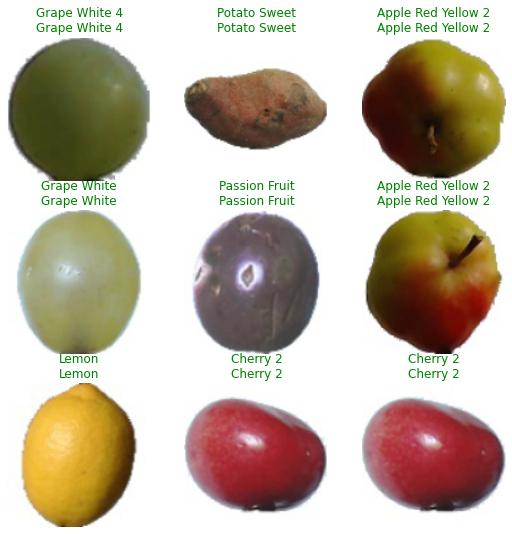

In [19]:
learn.show_results()

We can do a random prediction

In [20]:
learn.predict(test[99])[0]


'Apple Golden 3'

we can open the image to see if our model guess correctly

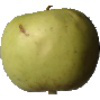

In [23]:
img = Image.open(test[99]).to_thumb(224)
img

It did, we can also do the reverse, see the image first and then do the prediction****

In [ ]:
img = Image.open(test[1000]).to_thumb(224)
img

In [ ]:
learn.predict(test[1000])[0]

It looks like our model makes good guesses now we will put in production.

Save our model as a serialised object using learn.export. We can use this for deployment.

In [ ]:
learn.export('/kaggle/working/export34.pkl')